In [1]:
%matplotlib inline

import altair
import pandas as pd
import numpy as np

from pandas import DataFrame
from overlay import shortcuts

# Import Altair
from vega import VegaLite
from altair import Chart, FacetedChart, X, Y, SortField, Axis, Size, Color

## Altair Demo

In this notebook I illustrate some basic plotting with the Altair libary. For an extensive tutorial check out the [Altair documentation](https://altair-viz.github.io/index.html).

## Data

In this notebook I made use of data from OpenFlights.org.

[Dataset information](http://openflights.org/data.html)
[github link](https://github.com/jpatokal/openflights)


### Caveat

Altair contains no visualization rendering code, it just generates vega-lite specs which are then parsed to vega and rendered in the browser. This means if we provide a dataframe to the Chart object we grow the size of the notebook because the specifications contain the data used in the visualisations. Unfortunately with larger datasets issue also crashes the notebook which has a limit on the amount of data which can be transfered into the browser (This is a notebook feature, not bug, designed to prevent very large strings being rendered in the browser).

>IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
--NotebookApp.iopub_data_rate_limit.

This issue has been flagged on github and is marked as a milestone in the next version. [Link](https://github.com/altair-viz/altair/issues/249) [Altair FAQ](https://altair-viz.github.io/faq.html#why-do-altair-plots-lead-to-such-extremely-large-notebooks). As a workaround one can save their data locally as csv or json and pass a url to the Chart object.

In [22]:
data = pd.read_csv(r'./data/data_raw.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54819 entries, 0 to 54818
Data columns (total 10 columns):
destination_airport      54819 non-null object
destination_country      54819 non-null object
destination_latitude     54819 non-null float64
destination_longitude    54819 non-null float64
records                  54819 non-null int64
source_airport           54819 non-null object
source_country           54819 non-null object
source_latitude          54819 non-null float64
source_longitude         54819 non-null float64
stops                    54819 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 4.2+ MB


## What else can we do with this dataset?

In this next section we will estimate the distance between the source and destination airports using the havesine formula. I just copied it from stack overflow and made adjustments to work with numpy arrays.

```python

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r
```

[Source](http://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points)

In [23]:
# Calculate the approximate distance between source and destination

def np_haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

data['distance'] = np_haversine(
    data.source_longitude, 
    data.source_latitude, 
    data.destination_longitude, 
    data.destination_latitude
)

In [24]:
# Calculate the number of stops

data['nr_stops'] = data.stops.apply(lambda x: len(x.split(' ')))

In [25]:
# Calculate if northern or southern hemisphere

data['source_hemisphere'] = np.where(
    data.source_latitude < 0,
    'S',
    'N'
)

data['destination_hemisphere'] = np.where(
    data.destination_latitude < 0,
    'S',
    'N'
)

data['flight_direction'] = data.source_hemisphere + data.destination_hemisphere

In [26]:
# Specify if it is international or domestic

data['flight_type'] = np.where(
    data.source_country == data.destination_country,
    'domestic',
    'international'
)

In [28]:
# Here is a full list of fields in our dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54819 entries, 0 to 54818
Data columns (total 16 columns):
destination_airport       54819 non-null object
destination_country       54819 non-null object
destination_latitude      54819 non-null float64
destination_longitude     54819 non-null float64
records                   54819 non-null int64
source_airport            54819 non-null object
source_country            54819 non-null object
source_latitude           54819 non-null float64
source_longitude          54819 non-null float64
stops                     54819 non-null object
distance                  54819 non-null float64
nr_stops                  54819 non-null int64
source_hemisphere         54819 non-null object
destination_hemisphere    54819 non-null object
flight_direction          54819 non-null object
flight_type               54819 non-null object
dtypes: float64(5), int64(2), object(9)
memory usage: 6.7+ MB


In [14]:
data.head()

,destination_airport,destination_country,destination_latitude,destination_longitude,records,source_airport,source_country,source_latitude,source_longitude,stops,distance,nr_stops,source_hemisphere,destination_hemisphere,flight_direction,flight_type
0,Adolfo Suárez Madrid–Barajas Airport,Spain,40.471926,-3.56264,1,A Coruña Airport,Spain,43.302101,-8.37726,321 319 320,507.673390,3,N,N,NN,domestic
1,Adolfo Suárez Madrid–Barajas Airport,Spain,40.471926,-3.56264,2,A Coruña Airport,Spain,43.302101,-8.37726,E90,507.673390,1,N,N,NN,domestic
2,Barcelona International Airport,Spain,41.297100,2.07846,2,A Coruña Airport,Spain,43.302101,-8.37726,320,887.676518,1,N,N,NN,domestic
3,Bilbao Airport,Spain,43.301102,-2.91061,2,A Coruña Airport,Spain,43.302101,-8.37726,320,442.296097,1,N,N,NN,domestic
4,Lisbon Portela Airport,Portugal,38.781300,-9.13592,1,A Coruña Airport,Spain,43.302101,-8.37726,BEH,506.694026,1,N,N,NN,international


In [29]:
# Save it locally to use as a url later

data.to_csv('data/data.csv')

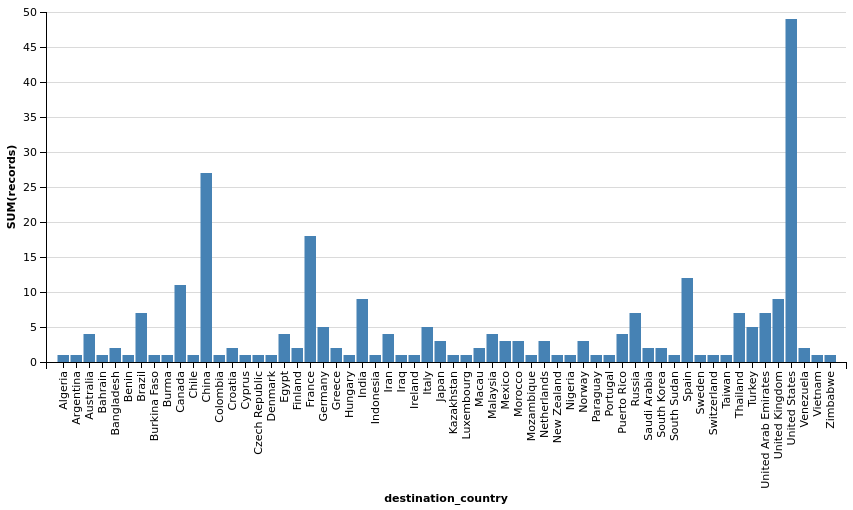

In [31]:
# This example illustrates how simple it is to build a basic bar chart.

sample = data.sample(200)

chart = Chart(
    data=sample,
    width=800
)

chart.mark_bar()

chart.encode(
    x='destination_country:N',
    y='sum(records):Q'
)

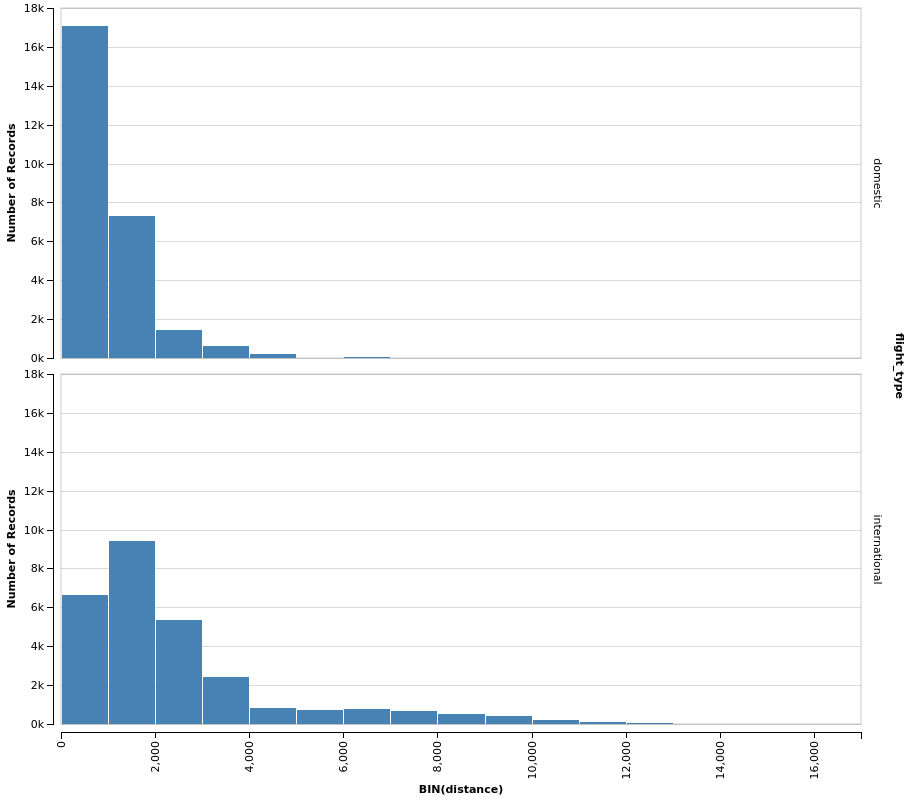

In [17]:
# Using the full dataset we can easily create a pair of histograms.


url = './data/data.csv'

chart = Chart(
    data=url,
    width=800
)

chart.mark_bar()
chart.encode(
    x=X('distance', bin=True),
    y='count(*):Q',
    row='flight_type'
    
)

## Something a little more invovled

To illustrate a few more features of Altair I decided to build a multi dimensional scatter chart (x, y, size and colour). The inspiration for this chart came from the [exploring weather](https://altair-viz.github.io/tutorials/exploring-weather.html) example in the Altair documentation. 

In [32]:
data_union = pd.concat(
    [
        data[['source_country', 'flight_type', 'flight_direction', 'distance', 'records']],
        data[['destination_country', 'flight_type', 'flight_direction', 'distance', 'records']]
    ]
)

data_union.rename(columns={'source_country': 'country'}, inplace=True)

In [69]:
group = data_union.groupby(['country', 'flight_type', 'flight_direction'])
summary = group.aggregate({
    'distance': {
        'min_distance': np.min,
        'max_distance': np.max,
        'mean_distance': np.mean
    },
    'records': {'nr_flights': np.sum}
})

summary.columns = summary.columns.get_level_values(1)
summary['range_distance'] = summary.max_distance - summary.min_distance
summary = summary.reset_index()

In [70]:
summary.head()

,country,flight_type,flight_direction,min_distance,max_distance,mean_distance,nr_flights,range_distance
0,Afghanistan,domestic,NN,299.030031,641.955599,492.759223,14,342.925569
1,Afghanistan,international,NN,220.883855,3588.628685,1415.372912,29,3367.744830
2,Albania,international,NN,249.238005,1864.456470,852.812138,36,1615.218465
3,Algeria,domestic,NN,120.382404,1558.202650,577.137409,82,1437.820246
4,Algeria,international,NN,295.642332,9104.074132,1545.440200,128,8808.431800


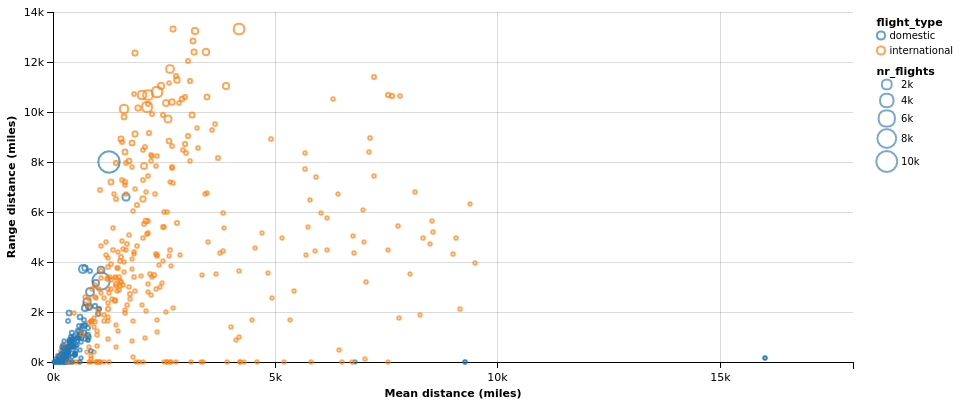

In [71]:
chart = Chart(summary, width=800)

chart.mark_point()
chart.encode(
    x=X('mean_distance', axis=Axis(title='Mean distance (miles)')),
    y=Y('range_distance', axis=Axis(title='Range distance (miles)')),
    color='flight_type:N',
    size='nr_flights:Q'
)